In [ ]:
#import libraries
import warnings
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Defaults
#plt.rcParams['figure.figsize'] = (12.0, 8.0)
#plt.rcParams.update({'font.size': 12})
plt.style.use('ggplot')

In [ ]:
!pip install reportlab

In [ ]:
from reportlab.lib.pagesizes import letter
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Image, Table, TableStyle
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.lib import colors


In [ ]:
import pandas as pd
from google.colab import files

# Upload a file from your local system
uploaded = files.upload()

doc = SimpleDocTemplate("report.pdf", pagesize=letter)

# Define styles
styles = getSampleStyleSheet()
heading1_style = styles["Heading1"]
subheading_style = ParagraphStyle('subheading', parent=styles['Normal'])
subheading_style.fontName = 'Helvetica-Bold'
subheading_style.fontSize = 12

# Create content for the PDF
content = []


# Iterate through the uploaded files
for filename in uploaded.keys():
    print(f'File "{filename}" uploaded successfully.')

    # Read the uploaded CSV file into a DataFrame
    data = pd.read_csv(filename,engine='python', skipfooter=3)
    # Display the DataFrame
content.append(Paragraph("Analysis Report of {}".format(filename), heading1_style))


Saving export-collection-all-properties-aura-boutique-monthly-sales-2024-04-11.csv to export-collection-all-properties-aura-boutique-monthly-sales-2024-04-11.csv
File "export-collection-all-properties-aura-boutique-monthly-sales-2024-04-11.csv" uploaded successfully.


In [ ]:
data.tail()

,Month,Aura Boutique Monthly Sales
137,2023-06,5359
138,2023-07,6221
139,2023-08,6064
140,2023-09,5080
141,2023-10,4618


In [ ]:
## Cleaning up the data
data = pd.DataFrame(data)

# Display the original DataFrame
print("Original DataFrame:")
print(data)



datasets = [data.head().values.tolist(), data.tail().values.tolist()]  # Example: First and last chunks
# Add a subheading for the dataset
content.append(Paragraph("Dataset", subheading_style))

for i, dataset in enumerate(datasets):
    # Add a subheading for the dataset
    content.append(Paragraph(f"Dataset {i+1}", subheading_style))

    # Extract number of columns
    num_columns = len(data.columns)

    # Add the dataset to the Pdata
    data_table = Table(dataset, repeatRows=1, colWidths=[None]*num_columns)
    data_table.setStyle(TableStyle([('BACKGROUND', (0,0), (-1,0), colors.grey),
                                   ('TEXTCOLOR', (0,0), (-1,0), colors.whitesmoke),
                                   ('ALIGN', (0,0), (-1,-1), 'CENTER'),
                                   ('FONTNAME', (0,0), (-1,0), 'Helvetica-Bold'),
                                   ('BOTTOMPADDING', (0,0), (-1,0), 12),
                                   ('BACKGROUND', (0,1), (-1,-1), colors.beige),
                                   ('GRID', (0,0), (-1,-1), 1, colors.black)]))
    content.append(data_table)



Original DataFrame:
       Month  Aura Boutique Monthly Sales
0    2012-01                         3112
1    2012-02                         2118
2    2012-03                         4132
3    2012-04                         1296
4    2012-05                         1211
..       ...                          ...
137  2023-06                         5359
138  2023-07                         6221
139  2023-08                         6064
140  2023-09                         5080
141  2023-10                         4618

[142 rows x 2 columns]


In [ ]:

# A bit of pre-processing to make it nicer
data['Month']=pd.to_datetime(data['Month'], format='%Y-%m')
data.set_index(['Month'], inplace=True)



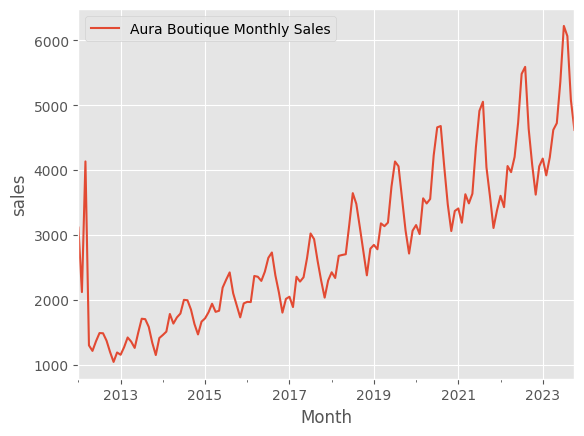

<Figure size 640x480 with 0 Axes>

In [ ]:
# Plot the data
data.plot()
plt.ylabel('sales')
plt.xlabel('Month')
plt.show()

plt.savefig('graph.png')
content.append(Image("graph.png"))

In [ ]:
data.head()

,Aura Boutique Monthly Sales
Month,
2012-01-01,3112
2012-02-01,2118
2012-03-01,4132
2012-04-01,1296
2012-05-01,1211


In [ ]:
rep=data.describe()
print(rep)
sales_summary = rep.to_string()

sales_summary_paragraph = Paragraph(sales_summary, styles["Normal"])
content.append(sales_summary_paragraph)


       Aura Boutique Monthly Sales
count                   142.000000
mean                   2829.654930
std                    1181.456518
min                    1041.000000
25%                    1834.500000
50%                    2683.000000
75%                    3599.750000
max                    6221.000000


In [ ]:
# Define the d and q parameters to take any value between 0 and 1 p- auto regressive terms, q-sesonal differenncing,d-movin average
q = d = range(0, 2)
# Define the p parameters to take any value between 0 and 3
p = range(0, 4)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [ ]:
train_data = data['2012-01-01':'2021-12-01']  #changes in the value of date
test_data = data['2022-01-01':'2023-09-01']

In [ ]:
"""warnings.filterwarnings("ignore") # specify to ignore warning messages

AIC = []
SARIMAX_model = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_data,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('SARIMAX{}x{} - AIC:{}'.format(param, param_seasonal, results.aic), end='\r')
            AIC.append(results.aic)
            SARIMAX_model.append([param, param_seasonal])
        except:
            continue"""

In [ ]:
AIC = []
SARIMAX_model = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_data,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('SARIMAX{}x{} - AIC:{}'.format(param, param_seasonal, results.aic), end='\r')
            AIC.append(results.aic)
            SARIMAX_model.append([param, param_seasonal])
        except:
            continue

# Select the SARIMAX model with the lowest AIC
best_model_idx = AIC.index(min(AIC))
best_param, best_param_seasonal = SARIMAX_model[best_model_idx]

# Fit the best model to the training data
best_mod = sm.tsa.statespace.SARIMAX(train_data,
                                     order=best_param,
                                     seasonal_order=best_param_seasonal,
                                     enforce_stationarity=False,
                                     enforce_invertibility=False)
best_results = best_mod.fit()


In [ ]:
print('The smallest AIC is {} for model SARIMAX{}x{}'.format(min(AIC),
       SARIMAX_model[AIC.index(min(AIC))][0],
       SARIMAX_model[AIC.index(min(AIC))][1]
      ))

The smallest AIC is 834.6883020549965 for model SARIMAX(3, 1, 0)x(3, 1, 1, 12)


In [ ]:
# Let's fit this model
"""mod = sm.tsa.statespace.SARIMAX(train_data,
                                order=SARIMAX_model[AIC.index(min(AIC))][0],
                                seasonal_order=SARIMAX_model[AIC.index(min(AIC))][1],
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()"""


'mod = sm.tsa.statespace.SARIMAX(train_data,\n                                order=SARIMAX_model[AIC.index(min(AIC))][0],\n                                seasonal_order=SARIMAX_model[AIC.index(min(AIC))][1],\n                                enforce_stationarity=False,\n                                enforce_invertibility=False)\n\nresults = mod.fit()'

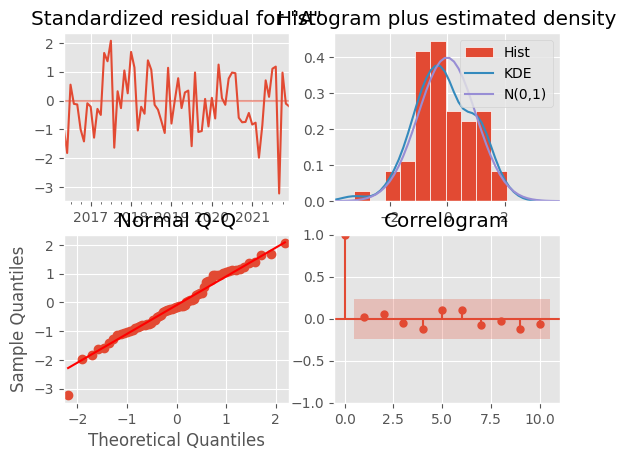

<Figure size 640x480 with 0 Axes>

In [ ]:
results.plot_diagnostics()
plt.show()

plt.savefig('graph2.png')
content.append(Image("graph2.png"))

In [ ]:
data['forecast']=results.predict(start=100,end=140,dynamic=True)
#data[['Sales','forecast']].plot()
data

,Aura Boutique Monthly Sales,forecast
Month,,
2012-01-01,3112,NaN
2012-02-01,2118,NaN
2012-03-01,4132,NaN
2012-04-01,1296,NaN
2012-05-01,1211,NaN
...,...,...
2023-06-01,5359,5239.903739
2023-07-01,6221,5559.789103
2023-08-01,6064,5551.400591


In [ ]:
pred0 = results.get_prediction(start='2012-01-01', dynamic=False)#predictions date values will change
pred0_ci = pred0.conf_int()
pred1 = results.get_prediction(start='2012-01-01', dynamic=True)
pred1_ci = pred1.conf_int()
pred2 = results.get_forecast('2024-12-01')
pred2_ci = pred2.conf_int()
print(pred2.predicted_mean['2022-01-01':'2023-10-01'])


2022-01-01    3421.963215
2022-02-01    3129.840373
2022-03-01    3576.003943
2022-04-01    3373.178155
2022-05-01    3596.106785
2022-06-01    4301.409729
2022-07-01    4927.552495
2022-08-01    5097.425094
2022-09-01    3952.327731
2022-10-01    3526.273636
2022-11-01    3035.264115
2022-12-01    3262.528939
2023-01-01    3335.202238
2023-02-01    2995.008163
2023-03-01    3461.411202
2023-04-01    3222.752354
2023-05-01    3476.444455
2023-06-01    4185.087134
2023-07-01    4856.926310
2023-08-01    5039.938055
2023-09-01    3834.065376
2023-10-01    3410.552914
Freq: MS, Name: predicted_mean, dtype: float64


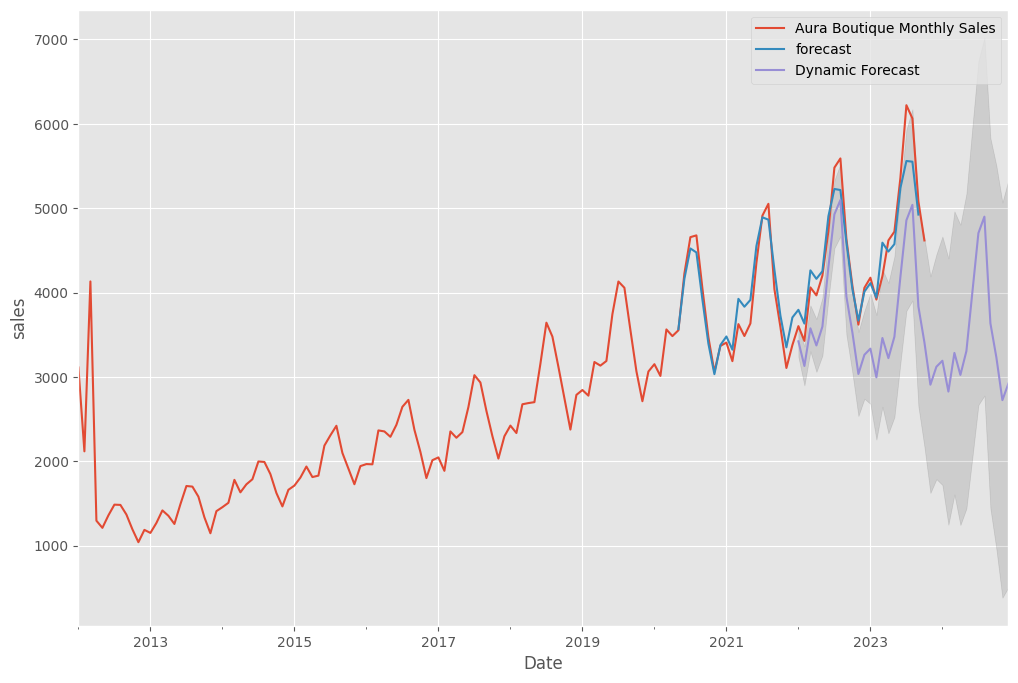

In [ ]:
ax = data.plot(figsize=(12, 8))
pred2.predicted_mean.plot(ax=ax, label='Dynamic Forecast')
ax.fill_between(pred2_ci.index, pred2_ci.iloc[:, 0], pred2_ci.iloc[:, 1], color='k', alpha=.1)
plt.ylabel('sales')
plt.xlabel('Date')
plt.legend()
plt.show()
plt.savefig('graph3.png')
content.append(Image("graph3.png"))

In [ ]:
data.describe()
data.shape

(142, 2)

In [ ]:
prediction = pred2.predicted_mean['2022-01-01':'2023-10-01'].values  #values will change
print(prediction)
# flatten nested list
truth = list(itertools.chain.from_iterable(test_data.values))
print(truth)


[3421.9632149  3129.84037305 3576.0039434  3373.17815519 3596.10678501
 4301.4097287  4927.55249522 5097.42509395 3952.32773118 3526.27363631
 3035.26411548 3262.5289392  3335.20223794 2995.00816334 3461.41120203
 3222.75235396 3476.44445499 4185.08713412 4856.92630972 5039.93805522
 3834.06537629 3410.55291423]
[3602, 3427, 4061, 3967, 4201, 4729, 5481, 5590, 4635, 4080, 3620, 4056, 4176, 3917, 4194, 4618, 4722, 5359, 6221, 6064, 5080]
